In [ ]:
import Pkg
Pkg.activate(".")
Pkg.add("QuantumOptics")
Pkg.add("DiffEqNoiseProcess")
Pkg.add("PyPlot")
Pkg.add("LaTeXStrings")
Pkg.add("Random")
Pkg.add("DelimitedFiles")
Pkg.add("NPZ")
Pkg.add("DifferentialEquations")
Pkg.add("SpecialFunctions")
Pkg.add("SparseArrays")
Pkg.add("StatsBase")
Pkg.add("Optim")
Pkg.add("JLD2")
Pkg.add("BenchmarkTools")
Pkg.add("OrdinaryDiffEq")
Pkg.add("StochasticDiffEq")
Pkg.add("DiffEqCallbacks")
Pkg.add("ProgressLogging")
Pkg.add("ProgressMeter")
Pkg.add("Dates")

In [9]:
using QuantumOptics
using DiffEqNoiseProcess
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim
using JLD2
using BenchmarkTools
include("HenryLib.jl")

make_white_noise (generic function with 1 method)

In [10]:
function dicke_model_SS_rho(λrel; κ=2π * 0.15, Δc=2π * 20, ωz=2π * 0.01, fockmax=4, Nspin=20)
    fb, sb, bases, a, Sx, Sy, Sz = make_operators(fockmax, Nspin)
    λc = 1 / 2 * sqrt((Δc^2 + κ^2) / Δc * ωz)
    λ = λrel * λc

    H0 = Δc * dagger(a) * a + ωz * Sz + 2 * λ * (dagger(a) + a) * Sx / sqrt(Nspin)
    C = sqrt(2 * κ) * a

    ρ_it = steadystate.iterative(H0, [C])

    return ρ_it, fb, sb, bases, a, Sx, Sy, Sz
end

dicke_model_SS_rho (generic function with 1 method)

In [41]:
λrels = LinRange(0.0, 3.0, 30)
Nspin = 10
fockmax = 10
λrel = 10.0

ρss, fb, sb, bases, a, Sx, Sy, Sz = dicke_model_SS_rho(λrel, Nspin=Nspin, fockmax=fockmax)

# Calculate photon number <a†a>
n = max(real(expect(dagger(a)*a, ρss)), 0.0)

0.01159000216542455

In [42]:
# Calculate steady state photon numbers at different λ values
photon_nums = []
λrels = LinRange(0.0, 40.0, 30)
Nspin = 100
fockmax = 4
for λrel in λrels
    # Get steady state density matrix
    ρss, fb, sb, bases, a, Sx, Sy, Sz = dicke_model_SS_rho(λrel, Nspin=Nspin, fockmax=fockmax)

    # Calculate photon number <a†a>
    n = max(real(expect(dagger(a)*a, ρss)), 0.0)
    push!(photon_nums, sqrt(n))
end


InterruptException: InterruptException:

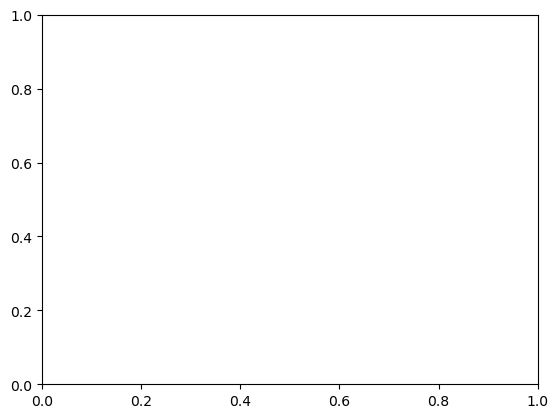

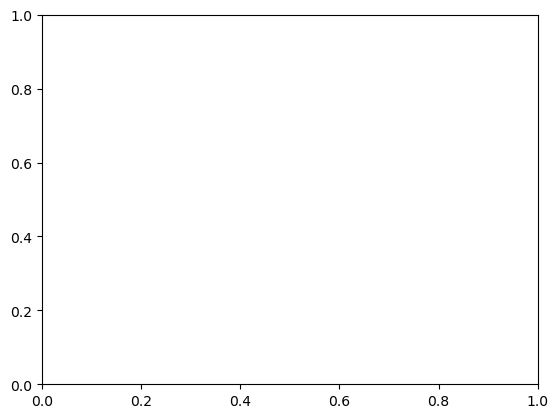

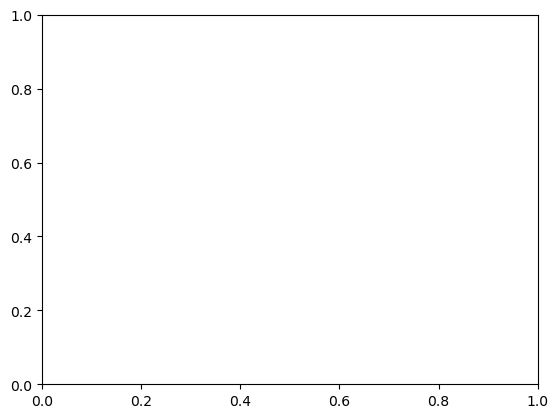

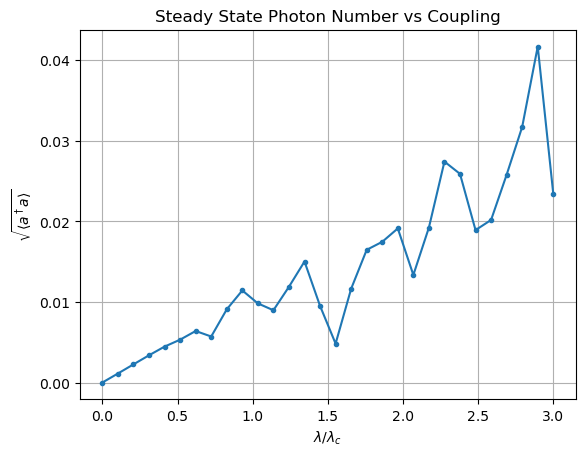

In [26]:
# Plot results
figure()
plot(λrels, photon_nums, ".-")
title("Steady State Photon Number vs Coupling")
xlabel(L"$\lambda/\lambda_c$")
ylabel(L"$\sqrt{\langle a^\dagger a \rangle}$")
grid(true)
PyPlot.display_figs()


In [ ]:
λrels = LinRange(0.0, 3.0, 30)
κ=200.0
Nspin=100

for λrel in λrels
    ρ_it, fb, sb, bases, a, Sx, Sy, Sz = dicke_model_SS_rho(λrel, κ=κ)
    recordtimes = 5000
    tspan = range(0.0, 500.0, recordtimes)
    g1 = timecorrelations.correlation(tspan, ρ_it, H0, [C], dagger(a), a)
    jldsave("SSRslts/lambda=$(round(λrel,digits=3))Nspin=$(Nspin).jld2"; ρ_it, g1)
end

In [3]:
LinRange(0.0, 3.0, 30)[6:8]

3-element LinRange{Float64, Int64}:
 0.517241,0.62069,0.724138

$$\frac{\tilde{g}^2 \kappa}{4 \Delta_c^2} Re[\alpha_+^* \alpha_-] s_z$$

$$\frac{\omega_z (\Delta_c^2 + \kappa^2) \kappa}{4 |\Delta_c|^3} 4|\omega_z/\Delta_c| s_z$$

$$\frac{\omega_z^2 (\Delta_c^2 + \kappa^2) \kappa}{|\Delta_c|^4}$$

In [14]:
ωz = 2π * 0.01
Δc = -2π * 80
κ = 2π * 0.15
αplus = Δc / (-Δc + ωz - im * κ) + Δc / (-Δc - ωz - im * κ)
αminus = Δc / (-Δc + ωz - im * κ) - Δc / (-Δc - ωz - im * κ)

gc = sqrt(ωz * (Δc^2 + κ^2) / abs(Δc))

g^2 * κ * real(conj(αplus) * αminus)/(4*Δc^2)

UndefVarError: UndefVarError: `g` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

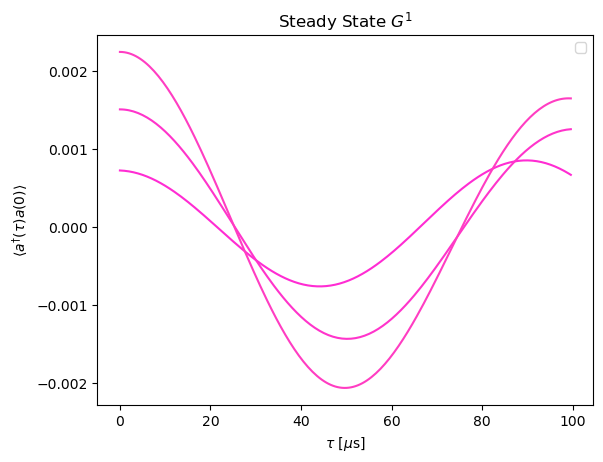

C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [2]:
λrels = LinRange(0.0, 3.0, 30)
short_list = λrels[1:7]
cm = get_cmap(:spring)
for λrel in λrels[6:8]
    rslt = load("SSRslts/lambda=$(round(λrel,digits=3))Nspin=100.jld2");
    tspan = range(0.0, 500.0, 1000)
    if real(rslt["g1"][1]) >= 0.
        plot(tspan[1:200], rslt["g1"][1:200], color=cm(λrel/λrels[end]))# label="\$\\lambda/\\lambda_c=$(round(λrel,digits=3))\$"
    else
        plot(tspan[1:200], -rslt["g1"][1:200], color=cm(λrel/λrels[end]))
    end
end
title("Steady State \$G^1\$")
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$\langle a^\dag (\tau) a(0) \rangle$")
ax = gca()
PyPlot.legend()
PyPlot.display_figs()

In [9]:
λrels = LinRange(0.0, 3.0, 30)
λrels[4:end]

27-element LinRange{Float64, Int64}:
 0.310345, 0.413793, 0.517241, 0.62069, …, 2.68966, 2.7931, 2.89655, 3.0

$\langle S_{x/y/z} \rangle = \frac{M}{2} s_{x/y/z}$

$g = \frac{\tilde{g}}{\sqrt{M}}$

$$1/\text{Dissipation Time} \approx \frac{\tilde{g} \kappa}{4 \Delta_c^2 M}$$

$$\tilde{g} = \omega_z(0) \frac{(\Delta_c^2 + \kappa^2)}{|\Delta_c|}$$

$$\text{Dissipation Time} = \frac{4 |\Delta_c|^3 M}{\omega_z(0) \kappa (\Delta_c^2 + \kappa^2)}$$

In [3]:
Δc = -2π * 80
κ = 2π * 1.0
Nspin = 10
ωz = 2π * 0.01

4*Nspin*abs(Δc)^3 / (ωz * κ * (Δc^2 + κ^2))*1e-6

0.05092162528545564